# **Neural Network from scratch - without use of libraries on MNIST Dataset**

## Objective
In this notebook, we'll explore the fundamentals of neural network implementation by building a basic neural network from scratch without relying on external deep learning libraries. Our goal is to create a simple yet effective neural network architecture and train it on the popular MNIST dataset.

## Introduction
Deep learning libraries like TensorFlow and PyTorch provide high-level abstractions for building and training neural networks, making it easier for practitioners to develop sophisticated models. However, understanding the inner workings of a neural network is crucial for gaining a solid grasp of deep learning concepts.

In this tutorial, we'll take a hands-on approach to demystify the building blocks of neural networks. The MNIST dataset, consisting of handwritten digit images, serves as an excellent foundation for our exploration.

## Key Objectives
1. **Implementing Neural Network Layers:** We will define the essential components of a neural network, including the input layer, hidden layers, activation functions, and the output layer.

2. **Forward and Backward Propagation:** Explore the mechanisms of forward and backward propagation for training the neural network.

3. **Loss Function and Optimization:** Understand the role of loss functions in evaluating the model's performance and optimization techniques like gradient descent.

4. **Training on MNIST Dataset:** Apply the developed neural network to classify handwritten digits from the MNIST dataset.

# 1. Load the libraries and dataset

In this section, we will import the necessary libraries and load the MNIST dataset. The MNIST dataset is a collection of handwritten digits widely used for training various image processing systems. We will use it to build a neural network from scratch.

We will use idx2numpy Python library. In the MNIST dataset, the images and labels are stored in binary format, and idx2numpy provides a convenient way to convert these binary files into NumPy arrays. It can be used to streamline the data loading process.

In [2]:
#Load the dataset
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [ ]:
#Install the library
!pip install idx2numpy

In [3]:
#Import the dataset and other python libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import struct
from array import array
from os.path import join

class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)
    
# Set file paths based on added MNIST Datasets
input_path = '../input'
training_images_filepath = join(input_path, 'mnist-dataset/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'mnist-dataset/train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 'mnist-dataset/t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 'mnist-dataset/t10k-labels.idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

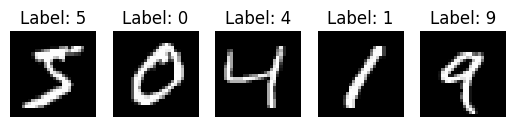

In [4]:
# Display a few images from the training set
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

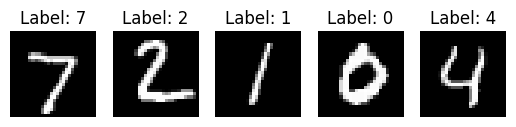

In [5]:
# Display a few images from the testing set
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

plt.show()

# 2. Understanding the layers

The following are the key steps that we will follow while building out network:

1. We feed input data into the neural network.
2. The data flows from layer to layer until we have the output.
3. Once we have the output, we can calculate the error which is a scalar.
4. Finally we can adjust a given parameter (weight or bias) by subtracting the derivative of the error with respect to the parameter itself.
5. We iterate through that process.

**Forward propagation**

We can already emphasize one important point which is: the output of one layer is the input of the next one. This is called **forward propagation**. By comparing the result of the network (Y) with the desired output (let’s say Y*), we can calculate en error E. The goal is to minimize that error by changing the parameters in the network. That is backward propagation (backpropagation).

**Gradient Descent**

To train our neural network, we will employ the gradient descent optimization algorithm. Gradient descent is an iterative optimization algorithm used to minimize the cost function. It adjusts the parameters of the model by moving in the direction of the steepest decrease in the cost. This iterative process continues until the algorithm converges to a minimum.

In simpler terms, we want to change some parameter in the network (call it w) so that the total error E decreases. Here, α is a parameter in the range [0,1] that we set and that is called the learning rate. We need to be able to find the value of ∂E/∂w expression for any parameter of the network regardless of its architecture.

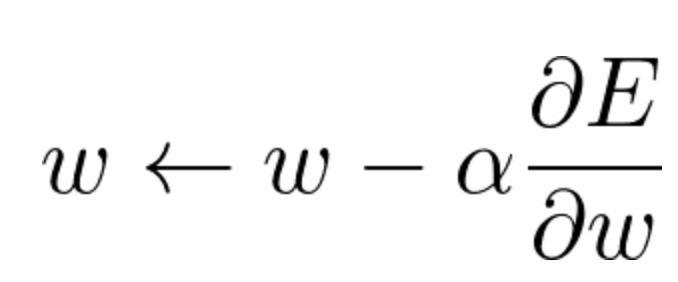

**Backward propagation**
After the forward pass, where input data moves through the neural network to make predictions, backward propagation is the step where the network learns from its mistakes. In simpler terms, it adjusts the internal parameters (weights and biases) based on the difference between predicted and actual outcomes. Think of it as a correction mechanism that helps the network improve its accuracy over time.
Suppose that we give a layer the derivative of the error with respect to its output (∂E/∂Y), then it must be able to provide the derivative of the error with respect to its input (∂E/∂X).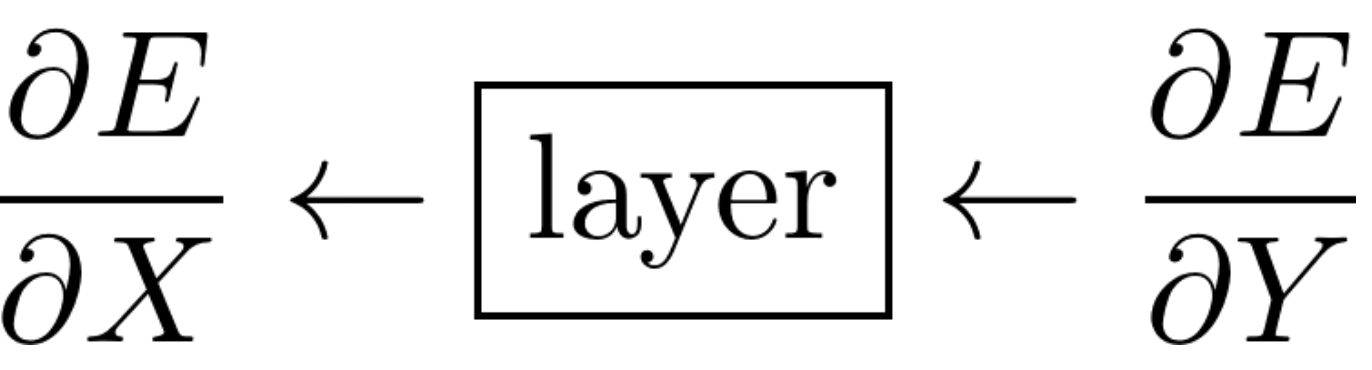

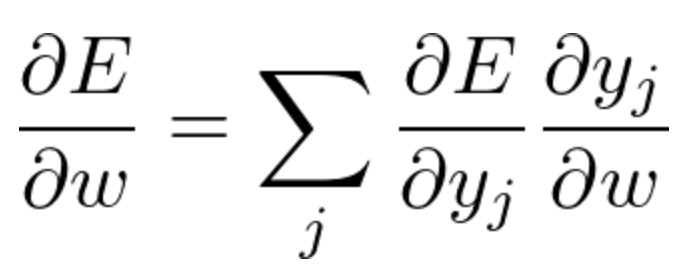

The unknown is ∂y_j/∂w which totally depends on how the layer is computing its output. So if every layer have access to ∂E/∂Y, where Y is its own output, then we can update our parameters !

The output of one layer is the input of the next layer. Which means ∂E/∂X for one layer is ∂E/∂Y for the previous layer! Again, we can use the chain rule :

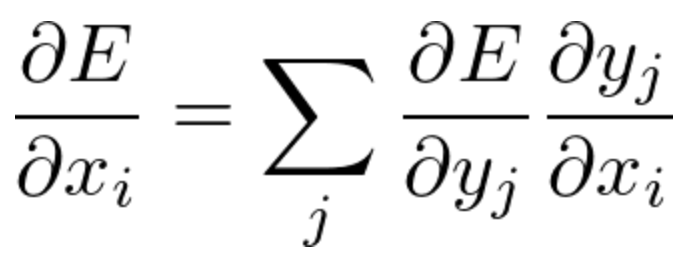

Simple summary of the working of the layers:
Layer 3 is going to update its parameters using ∂E/∂Y, and is then going to pass ∂E/∂H2 to the previous layer, which is its own “∂E/∂Y”. Layer 2 is then going to do the same, and so on and so forth.

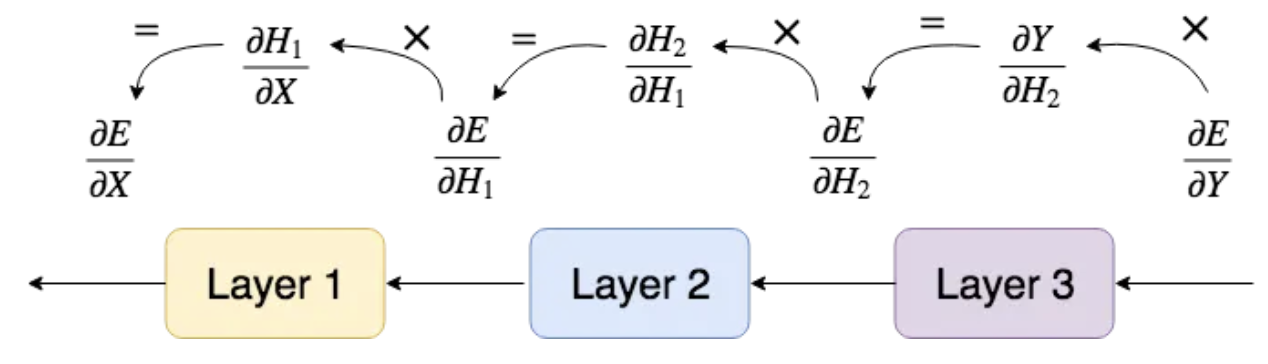



# 3. Code the Base Class

Abstract Base Class Layer
The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [6]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

# 4. Fully Connected Layer

FC layers are the most basic layers as every input neurons are connected to every output neurons.
For Forward Propogation in a FC layer, the value of each output neuron can be calculated as the following :

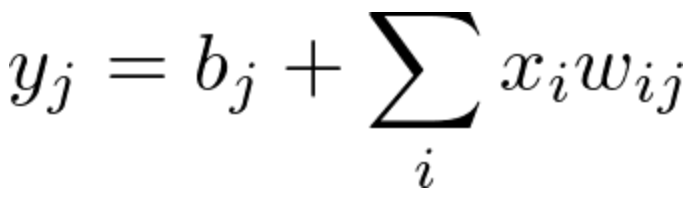

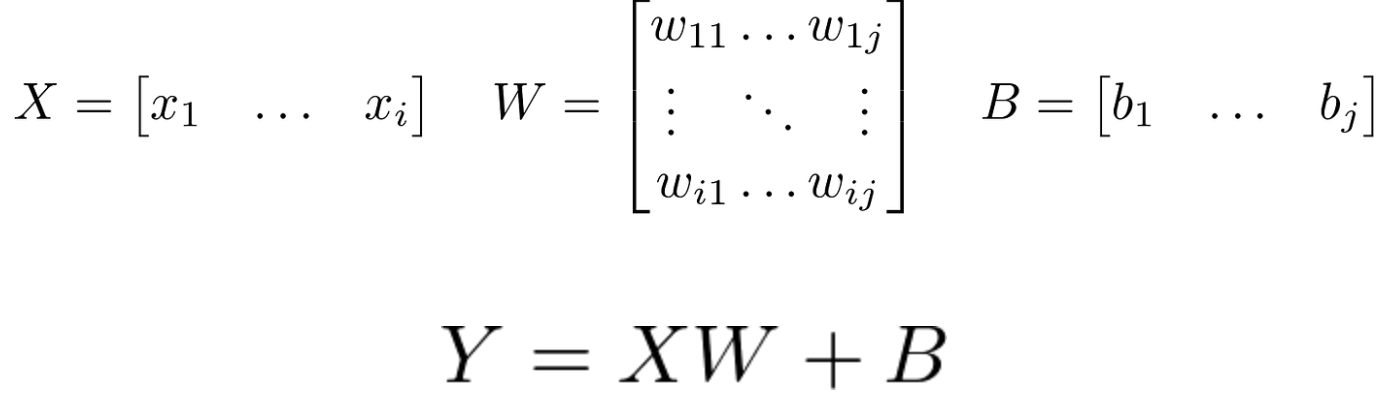

For BackPropogation in a FC layer:
To calculate the error derivative with respect to the output, we would need:

1. The derivative of the error with respect to the parameters (∂E/∂W, ∂E/∂B)
2. The derivative of the error with respect to the input (∂E/∂X)

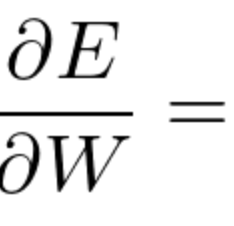 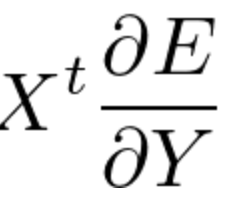

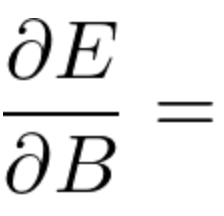 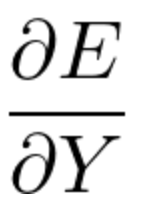

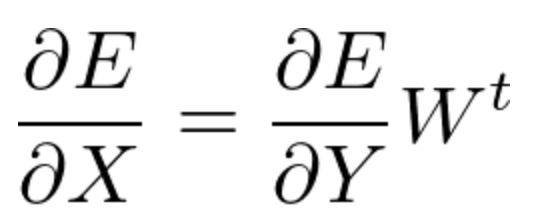

**Custom Fully Connected Layer Implementation**

The below piece of code defines a custom Fully Connected Layer (FCLayer) for a neural network. It inherits from a base class `Layer` (which is defined above) and includes methods for forward propagation and backward propagation.

1. `__init__(self, input_size, output_size)`: Initializes the layer with random weights and biases.

2.  `forward_propagation(self, input_data)`: Computes the layer's output given an input.

3. `backward_propagation(self, output_error, learning_rate)`: Adjusts the layer's parameters based on the output error and returns the input error.

In [7]:
# inherit from base class Layer: Fully connected layer code
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

# 5. Activation Layer

In a neural network, an activation layer introduces non-linearity to the model. It applies a mathematical function to each neuron's output, adding flexibility and complexity to the network's representations.

- **Purpose**: Enhances the model's capacity to learn and capture intricate patterns in data.Common activation functions include ReLU (Rectified Linear Unit), Sigmoid, and Tanh.

Forward Propagation
For a given input X , the output is simply the activation function applied to every element of X . Which means input and output have the same dimensions.

Backward Propagation
Given ∂E/∂Y, we want to calculate ∂E/∂X.

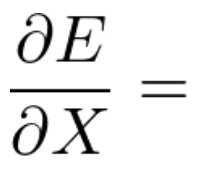 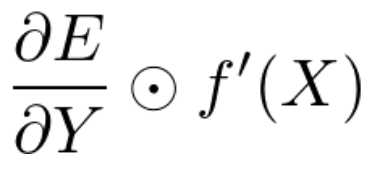

**Activation Layer Implementation**

The ActivationLayer is implemented by inherting from the base class: Layer
*  **Initialization**: The layer is initialized with two functions, activation and activation_prime. These functions represent the activation and its derivative, respectively.

*  **Forward Propagation**: During forward propagation, the layer applies the activation function to the input data, producing the activated output.

*  **Backward Propagation**: For backward propagation, it computes the input error (`dE/dX`) given the output error (`dE/dY`). The derivative of the activation function (activation_prime) is crucial in this step.

In [8]:
# inherit from base class Layer: Activation Layer code
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [9]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

# 6. Loss Function

The Loss Function is a crucial element in training a neural network, acting as a guide for the optimization process.

* **Objective**: The primary goal of a neural network is to minimize the loss function. The loss quantifies the difference between the predicted output and the actual target values.

* **Types**: Various types of loss functions exist, each suitable for specific tasks. For example, Mean Squared Error (MSE) is common for regression problems, while Cross-Entropy Loss is prevalent in classification tasks.

* **Optimization**: During training, the model adjusts its parameters to minimize the loss. This is achieved through optimization algorithms like Gradient Descent, which iteratively updates the model based on the gradients of the loss with respect to its parameters.

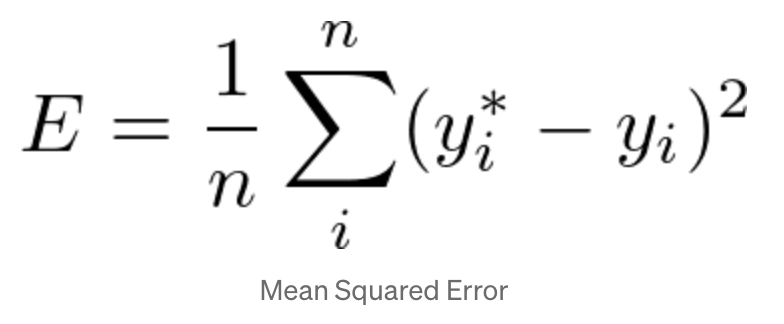

y* and y denotes desired output and actual output respectively.

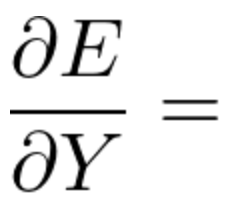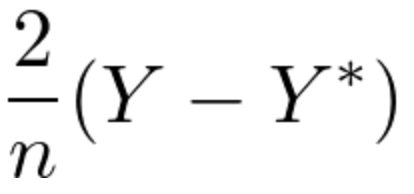

**Loss Function Implementation**

The below code defines a Mean Squared Error (MSE) loss function and its derivative:

**Mean Squared Error (MSE) Loss Function:**
The mse function calculates the mean of the squared differences between the true values (y_true) and the predicted values (y_pred). It quantifies the average magnitude of the errors.

**MSE Derivative:**
The mse_prime function computes the derivative of the MSE loss with respect to the predicted values. This derivative is crucial for the optimization process, such as in the Gradient Descent algorithm, guiding how much the model parameters should be adjusted during training.

In [10]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

#def mse(y_true, y_pred):
    #return np.mean(np.power(np.squeeze(y_true) - np.squeeze(y_pred), 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

# 7. Neural Network Implementation

The below code defines a basic neural network class named Network. 

* __init__ Method: Initializes the neural network with an empty list of layers and placeholders for the loss function and its derivative.

* add Method: Adds a layer to the neural network.

* use Method: Sets the loss function and its derivative for the network.

* predict Method: Predicts the output for a given input by performing forward propagation through all the layers.

* fit Method: Trains the neural network on the provided training data (`x_train`, `y_train`) using a specified number of epochs and learning rate. 
    It includes a training loop that iterates through each epoch and sample, performing forward and backward propagation for each sample.
    The loss is computed during training for display purposes.

In [11]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

# 8. NN on MNIST Dataset

The below code demonstrates the preprocessing of the MNIST dataset using Keras utilities and the initialization of a neural network using the above defined methods.

**Data Preprocessing:**
1. **Conversion to NumPy Arrays:** The dataset (x_train, y_train, x_test, y_test) is converted to NumPy arrays. The conversion of the dataset to NumPy arrays is carried out to leverage the efficient numerical computation capabilities provided by NumPy. Neural network operations, such as matrix multiplications and element-wise operations, are more optimized and faster when performed using NumPy arrays.

2. **Reshaping and Normalization:** The input data (x_train and x_test) is reshaped to have dimensions (samples, 1, 28*28). Each image in the dataset is transformed into a 3D array where the first dimension is the number of samples, the second dimension is the number of channels (treated as 1 in this case -  because its grayscale), and the third dimension is the flattened representation of the image (28*28 pixels).
Input values are normalized to the range [0, 1] by dividing by 255. The normalization step is essential to scale input values to a range between 0 and 1. By dividing each pixel value by 255, the normalization facilitates more stable and efficient training of the neural network, preventing large input values from dominating the learning process.

3. **One-Hot Encoding:** The output labels (y_train and y_test) are one-hot encoded using Keras to_categorical function. One-hot encoding transforms categorical labels into a binary matrix where each column corresponds to a unique class, and a '1' in a specific column indicates the presence of that class. In the case of MNIST:

    Original label '3' becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

    Original label '7' becomes [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

**Neural Network Initialization:**
1. **Network Setup:**
   - A neural network (net) is initialized using a custom implementation with layers.
   - The layers are added to the network, including fully connected layers (FCLayer) and activation layers (ActivationLayer) with tanh activation functions.
   

2. **Training:**
   - The network is trained for 35 epochs with a learning rate of 0.1.
   - Mean Squared Error (MSE) is used as the loss function (mse) during training.
   

3. **Testing:**
   - The trained network is tested on a small subset of samples from the test data (x_test) to demonstrate predictions.

In [12]:
from keras.utils import to_categorical

# training data : 60000 samples
# Convert x_train and x_test to NumPy array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255

# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255

# encode test output which is a number in range [0,9] into a vector of size 10
y_test = to_categorical(y_test)

# Network with 3 FC layers
net = Network()
# Print the layers of the network
for layer in net.layers:
    print(layer)

net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=35, learning_rate=0.1)

# test
out = net.predict(x_test)

2024-02-24 12:45:26.050186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 12:45:26.050293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 12:45:26.175594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


epoch 1/35   error=0.041630
epoch 2/35   error=0.019533
epoch 3/35   error=0.015543
epoch 4/35   error=0.013335
epoch 5/35   error=0.011874
epoch 6/35   error=0.010771
epoch 7/35   error=0.009933
epoch 8/35   error=0.009206
epoch 9/35   error=0.008593
epoch 10/35   error=0.008094
epoch 11/35   error=0.007651
epoch 12/35   error=0.007242
epoch 13/35   error=0.006862
epoch 14/35   error=0.006578
epoch 15/35   error=0.006268
epoch 16/35   error=0.006018
epoch 17/35   error=0.005785
epoch 18/35   error=0.005578
epoch 19/35   error=0.005423
epoch 20/35   error=0.005209
epoch 21/35   error=0.005073
epoch 22/35   error=0.004930
epoch 23/35   error=0.004768
epoch 24/35   error=0.004614
epoch 25/35   error=0.004509
epoch 26/35   error=0.004391
epoch 27/35   error=0.004275
epoch 28/35   error=0.004199
epoch 29/35   error=0.004112
epoch 30/35   error=0.004014
epoch 31/35   error=0.003937
epoch 32/35   error=0.003868
epoch 33/35   error=0.003810
epoch 34/35   error=0.003742
epoch 35/35   error=0.0

# 9. Calculate the Evaluation metrics

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert out to a NumPy array and squeeze the extra dimension
out = np.array(out)
out = np.squeeze(out)

# Calculate true labels
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.sum(np.argmax(out, axis=1) == true_labels) / len(true_labels)
print(f"Accuracy: {accuracy * 100:.2f}% \n")

# Generate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(out, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(true_labels, np.argmax(out, axis=1))
print("\n Classification Report:")
print(class_report)

Accuracy: 96.15% 

Confusion Matrix:
[[ 969    0    1    1    2    1    1    1    4    0]
 [   0 1119    4    4    0    3    1    1    3    0]
 [   5    2  979   17    6    6    3    8    6    0]
 [   1    0    6  979    0   10    1    6    4    3]
 [   1    2    2    7  943    0    7    2    2   16]
 [   4    0    0   12    2  854    9    2    4    5]
 [  11    2    7    8    5    9  914    0    2    0]
 [   1    7   14   12    1    1    0  979    1   12]
 [   2    2    3   20    3    6    4    3  930    1]
 [   3    4    1   24   13    2    1    7    5  949]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.90      0.97      0.94      1010
           4       0.97      0.96      0.96       982
           5       0.96      0.96      0.96       892
           6       0.97     

# 10. Visualize the result dataset

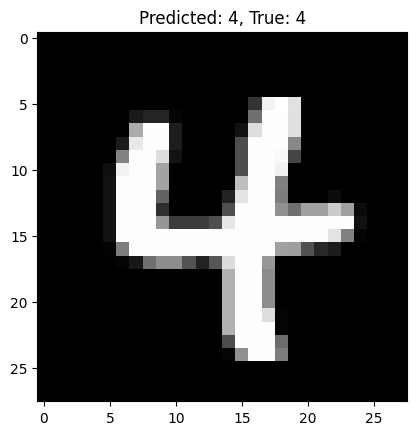

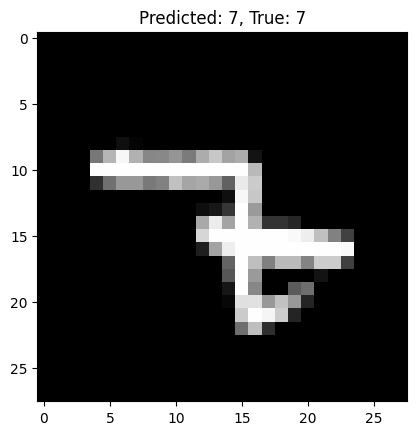

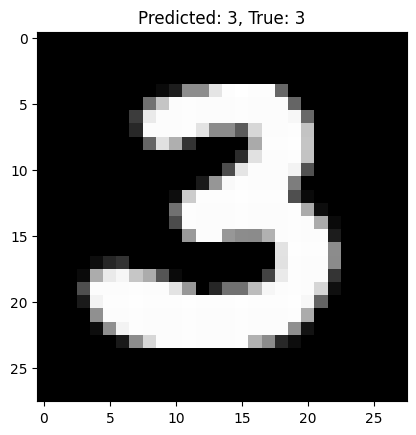

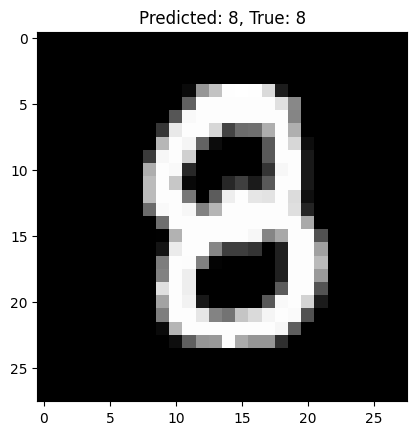

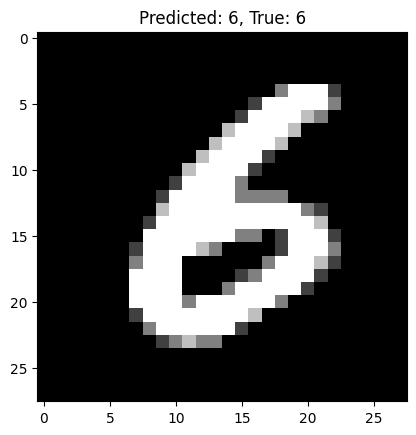

In [16]:
import matplotlib.pyplot as plt

# Choose a few random indices to visualize
indices = np.random.choice(len(x_test), size=5, replace=False)

for index in indices:
    # Get the predicted and true labels
    predicted_label = np.argmax(out[index])
    true_label = np.argmax(y_test[index])

    # Reshape the image to (28, 28) for plotting
    image = x_test[index].reshape((28, 28))

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted: {predicted_label}, True: {true_label}")
    plt.show()


**References**

* https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65